<a href="https://colab.research.google.com/github/mukund-rajukumar/My-VisionAI-Projects/blob/main/FoodAndBevPackageDetection/Detection_with_LLAMA3V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Llamma 3.2 Introduction
Llama 3.2 family of multimodal models with vision capabilities were released by Meta less than a month ago: [Meta Blog](https://ai.meta.com/blog/llama-3-2-connect-2024-vision-edge-mobile-devices/) <br>

The 2 variants of the vision LLMs (11B and 90B) are much smaller only requiring compute resources that AI researchers like me can access and afford via Google Colab compared to their original humongous Llama 3.1 405B model. They both support visual understanding tasks like describing the image in detail, reading text and directionally pinpointing objects in images.

To support image reasoning, Llama 3.2-Vision uses a separately trained vision adapter that integrates on top of the Llama 3.1 auto-regressive text-only LLM.




In [1]:
%pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 79.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [73]:
#@title Install Dependencies
import importlib.util # Import the importlib module

if importlib.util.find_spec('tabulate') is None:
  %pip install tabulate

if importlib.util.find_spec('timm') is None:
  %pip install timm

if importlib.util.find_spec('torch') is None:
  %pip install torch

if importlib.util.find_spec('openai') is None:
  %pip install openai
from openai import OpenAI

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import numpy as np
import os
import yaml
import time
import re

import torch

import math
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode

from pathlib import Path

import requests, base64, io

import transformers
#from transformers import AutoTokenizer, AutoModel
from transformers import MllamaForConditionalGeneration, AutoProcessor

In [45]:
#@title Set API Access Tokens for Nvidia developer site, OpenAI and HuggingFace
if os.environ.get('HOME') == "/Users/mukund" or os.environ.get('HOME') == "/Users/Mukund":
  import json
  %cd '/Users/mukund/Documents/HealthyYouVendingProject'
  print("Warning: Not running in Google Colab. Some functionalities may be limited.")
  with open('credentials.json', 'r') as f:  # Open the file in read mode ('r')
    credentials = json.load(f)
  nv_nim_token=credentials['nv-nim-token']
  openai_api_key = credentials['OPENAI-API-KEY']
  hf_token=credentials['HF-W-TOKEN']
else:
  import google.colab
  from google.colab import userdata
  nv_nim_token = userdata.get('nv-nim-token')
  openai_api_key = userdata.get('OPENAI-API-KEY')
  hf_token=userdata.get('HF-W-TOKEN')

/Users/mukund/Documents/HealthyYouVendingProject


/opt/homebrew/Cellar/jupyterlab/4.2.3/libexec/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
#@title Function: Load class names from yaml file

def load_class_labels(yaml_path):
  """Loads class labels from a YAML file.

  Args:
      yaml_path (str): The path to the YAML file containing the class labels.

  Returns:
      list: A list of class labels.
  """

  with open(yaml_path, 'r') as file:
    data = yaml.safe_load(file)
  return data['names']  # 'names' contains the list of class labels

In [5]:
#@title Function: Extract bounding boxes and class names from Yolo format test data and overlay on image

def extract_and_plot_image_bboxes(img, label_path, class_labels):
  """Extracts bounding boxes and class labels from a label file and plots them on an image.

  Args:
      img (Image.Image): The image to plot the bounding boxes on.
      label_path (str): The path to the label file containing bounding box information.
      class_labels (list): A list of class labels corresponding to the class IDs in the label file.

  Returns:
      list: A list of dictionaries containing extracted image label information (class ID and bounding box coordinates).

  Raises:
      ValueError: If the label file format is invalid (expected format: class_id x_center y_center width height per line).
  """

  # Create a plot
  fig, ax = plt.subplots(1, figsize=(10, 10))
  ax.imshow(img)

  # Read the label file and extract bounding boxes
  image_labels = []
  try:
    with open(label_path, 'r') as f:
      for line in f.readlines():
        class_id, x_center, y_center, width, height = map(float, line.split())
        # Convert normalized coordinates to absolute pixel values
        x1n = (x_center - width / 2)
        y1n = (y_center - height / 2)
        x2n = (x_center + width / 2)
        y2n = (y_center + height / 2)
        image_labels.append({'class_id': class_id, 'bbox': (x1n, y1n, x2n, y2n)})
  except ValueError:
    raise ValueError(f"Invalid label file format. Expected format: class_id x_center y_center width height per line.")

  # Plot bounding boxes and labels
  for image_label in image_labels:
    class_id = image_label['class_id']
    x1n, y1n, x2n, y2n = image_label['bbox']
    img_w, img_h = img.size
    width_abs = (x2n - x1n) * img_w
    height_abs = (y2n - y1n) * img_h
    x_min = x1n * img_w
    y_min = y1n * img_h

    # Create a rectangle patch for the bounding box
    rect = patches.Rectangle((x_min, y_min), width_abs, height_abs, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Optionally, annotate the class label
    ax.text(x_min, y_min, class_labels[class_id], color='white', fontsize=12, bbox=dict(facecolor='r', edgecolor='r'))

  # Show the plot
  plt.show()
  return image_labels

In [22]:

#@title Function: Extract Label names and bounding boxes from LLM response

def extract_pred_labels_llama3_2_11b(text, image):
  """Parses the LLM output text to extract predicted labels and bounding boxes.

  Args:
      text (str): The text output from the LLM API containing product names and bounding boxes.
      image (Image.Image): The image for which the labels were generated by the LLM.

  Returns:
      list: A list of dictionaries, where each dictionary represents a product with its
          name and bounding box coordinates.

  Raises:
      ValueError: If the provided regular expression pattern for parsing the LLM output is invalid.
  """
  # The input text to parse
  # Define a regular expression pattern to match product names and bounding box coordinates
  # pattern = r"(\d+) (\d+) (\d+) (\d+) (.+)" #72 388 153 444 Utz Potato Chips
  # pattern = r"(\w[\w\s'’\-]+)\s" #Utz Potato Chips [64 395 158 455] \nDoritos Spicy Nacho [59, 464, 162, 534]

  pattern = r"[\d.] (\w+.*): \[([\d.]+), ([\d.]+), ([\d.]+), ([\d.]+)\]"
  try:
    # Find all matches in the text
    matches = re.findall(pattern, text)
  except re.error as e:
    raise ValueError(f"Invalid regular expression pattern for parsing LLM output: {pattern}") from e

  # Create a list of dictionaries to store product name and bounding box coordinates
  pred_labels = []
  for match in matches:
    # Extract bounding box coordinates and product name
    # For pattern = r"(\d+) (\d+) (\d+) (\d+) (.+)" #72 388 153 444 Utz Potato Chips
    # bbox = (int(match[0])/1000, int(match[1])/1000, int(match[2])/1000, int(match[3])/1000)  # Assuming x1, y1, x2, y2 order
    # product_name = match[4]

    # For pattern = r"(\w[\w\s'’\-]+)\s" #Utz Potato Chips [64 395 158 455] \nDoritos Spicy Nacho [59, 464, 162, 534]
    bbox = (int(match[2])/1000, int(match[1])/1000, int(match[4])/1000, int(match[3])/1000)  # Assuming y1, x1, y2, x2 order
    product_name = match[0]

    # Create a dictionary to store product information
    pred_labels.append({"label": product_name,
                        "bbox": bbox})

  # Plot the image with classification info overlaid
  width, height = image.size

  # Create figure and axes
  fig, ax = plt.subplots(1, figsize=(10, 10))

  # Display the image
  ax.imshow(image)

  # Plot the bounding boxes
  for product in pred_labels:
    print(product)
    bbox = product['bbox']
    # Denormalize the bounding box to image size
    x1, y1, x2, y2 = bbox

    x1 = int(x1 * width)
    x2 = int(x2 * width)
    y1 = int(y1 * height)
    y2 = int(y2 * height)

    # Create a rectangle
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
    # Add the rectangle to the plot
    ax.add_patch(rect)

    # Annotate with the product's brand and name
    ax.text(x1, y1 - 5, product['label'], color='yellow', fontsize=12, bbox=dict(facecolor='g', edgecolor='g'))

  # Show the plot
  plt.show()
  return pred_labels

In [141]:
#@title Function: Get Unique filename to save results
def get_unique_filename(base_filename):
  """
  Adds a numeral to the filename if it already exists.
  """
  filename, file_extension = os.path.splitext(base_filename)
  counter = 1
  unique_filename = base_filename

  while os.path.exists(unique_filename):
      unique_filename = f"{filename}_{counter}{file_extension}"
      counter += 1

  return unique_filename

In [146]:
#@title Function: Format response into table format with OpenAI API call
def format_response_into_table(text):

  # Prepare the prompt for the API
  prompt = f"Extract the product names and their corresponding bounding box coordinates in [xmin, ymin, xmax, ymax] format from the following text and provide in data frame format:\n{text}"

  client = OpenAI(api_key=openai_api_key)

  response = client.chat.completions.create(
      messages=[
          {"role": "user", "content": prompt}
      ],
      model="gpt-3.5-turbo",
      max_tokens=1024
  )

  # Print the response from the API
  fmt_text = response.choices[0].message.content
  return fmt_text


In [150]:
#@title Function: Extract Label names and bounding boxes from Llama3.2 response

def extract_pred_labels_llama3_2_90b(text, image, bbox_fmt):
  """Parses the LLM output text to extract predicted labels and bounding boxes.

  Args:
      text (str): The text output from the LLM API containing product names and bounding boxes.
      image (Image.Image): The image for which the labels were generated by the LLM.

  Returns:
      list: A list of dictionaries, where each dictionary represents a product with its
          name and bounding box coordinates.

  Raises:
      ValueError: If the provided regular expression pattern for parsing the LLM output is invalid.
  """
  pattern = r'\|\s*([\w\s]*)\|\s*\[([\d.]+), ([\d.]+), ([\d.]+), ([\d.]+)\]'
  try:
    # Find all matches in the text
    matches = re.findall(pattern, text)
  except re.error as e:
    raise ValueError(f"Invalid regular expression pattern for parsing LLM output: {pattern}") from e

  # Create a list of dictionaries to store product name and bounding box coordinates
  pred_labels = []
  for match in matches:
    # Extract bounding box coordinates and product name
    # For pattern = r"(\d+) (\d+) (\d+) (\d+) (.+)" #72 388 153 444 Utz Potato Chips
    # bbox = (int(match[0])/1000, int(match[1])/1000, int(match[2])/1000, int(match[3])/1000)  # Assuming x1, y1, x2, y2 order
    # product_name = match[4]

    if bbox_fmt == 'x1y1x2y2':
      bbox = (float(match[1]), float(match[2]), float(match[3]), float(match[4]))
    elif bbox_fmt == 'y1x1y2x2':
      bbox = (float(match[2]), float(match[1]), float(match[4]), float(match[3]))

    product_name = match[0].rstrip()

    # Create a dictionary to store product information
    pred_labels.append({"label": product_name,
                        "bbox": bbox})

  # Plot the image with classification info overlaid
  width, height = image.size

  # Create figure and axes
  fig, ax = plt.subplots(1, figsize=(10, 10))

  # Display the image
  ax.imshow(image)

  # Plot the bounding boxes
  for product in pred_labels:
    print(product)
    bbox = product['bbox']
    # Denormalize the bounding box to image size
    x1, y1, x2, y2 = bbox

    x1 = int(x1 * width)
    x2 = int(x2 * width)
    y1 = int(y1 * height)
    y2 = int(y2 * height)

    # Create a rectangle
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
    # Add the rectangle to the plot
    ax.add_patch(rect)

    # Annotate with the product's brand and name
    ax.text(x1, y1 - 5, product['label'], color='yellow', fontsize=12, bbox=dict(facecolor='g', edgecolor='g'))

  # Show the plot
  plt.show()
  return pred_labels

In [159]:
#@title Function: Plot ground truth and predicted bounding boxes on image

def get_pred_and_plot_results(img, pred_labels, ref_labels):
  """Plots both reference and predicted bounding boxes with IoU on the same image.

  Args:
      img (Image.Image): The image to plot the bounding boxes on.
      pred_results (list): A list of dictionaries containing reference and predicted label information
          (including bounding boxes and IoU).

  Raises:
      ValueError: If the predicted results list does not contain the expected keys ('ref_label', 'pred_label', 'iou').
  """

  pred_results = []
  for pred_label in pred_labels:
    px1, py1, px2, py2 = pred_label['bbox']
    max_iou = 0
    max_iou_ind = 0
    iou2 = 0
    iou2_ind = 0
    class_id = 0
    for index, ref_label in enumerate(ref_labels):
      rx1, ry1, rx2, ry2 = ref_label['bbox']
      cid = ref_label['class_id']
      iou = calculate_iou((rx1, ry1, rx2, ry2), (px1, py1, px2, py2))
      if iou > max_iou:
        max_iou = iou
        max_iou_ind = index
        class_id = cid
      elif iou > iou2:
        iou2 = iou
        iou2_ind = index
      # print(f"ref: {rx1:.3f} {ry1:.3f} {rx2:.3f} {ry2:.3f}, pred: {px1:.3f} {py1:.3f} {px2:.3f} {py2:.3f}, iou: {iou:.3f}")

    pred_results.append({'pred_label': pred_label, 'ref_label': ref_labels[max_iou_ind], 'iou': max_iou, 'class_name':class_labels[class_id], 'iou2': iou2, 'ref_label2': class_labels[ref_labels[iou2_ind]['class_id']]})

  # Create a plot
  fig, ax = plt.subplots(1, figsize=(10, 10))
  ax.imshow(img)

  # Validate predicted results format
  if not all(key in pred_result for key in ['ref_label', 'pred_label', 'iou'] for pred_result in pred_results):
    raise ValueError("Invalid format for predicted results. Expected dictionaries with 'ref_label', 'pred_label', and 'iou' keys.")

  for pred_result in pred_results:
    rx1n, ry1n, rx2n, ry2n = pred_result['ref_label']['bbox']
    px1n, py1n, px2n, py2n = pred_result['pred_label']['bbox']

    # Calculate image dimensions and absolute bounding box coordinates
    img_w, img_h = img.size
    rwidth_abs = (rx2n-rx1n) * img_w
    rheight_abs = (ry2n-ry1n) * img_h
    rx_min = rx1n*img_w
    ry_min = ry1n*img_h

    # Create a rectangle patch for the bounding box
    rect = patches.Rectangle((rx_min, ry_min), rwidth_abs, rheight_abs, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

    pwidth_abs = (px2n-px1n) * img_w
    pheight_abs = (py2n-py1n) * img_h
    px_min = px1n*img_w
    py_min = py1n*img_h

    # Create a rectangle patch for the bounding box
    rect = patches.Rectangle((px_min, py_min), pwidth_abs, pheight_abs, linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    # show IoU for each predicted label
    ax.text(px_min, py_min, f"{pred_result['iou']:.3f}", color='white', fontsize=12, bbox=dict(facecolor='r', edgecolor='r'))

  # Show the plot
  plt.title(f"IoU of bounding Boxes (Ground Truth in GREEN, Prediction in BLUE)")
  plt.show()

  return pred_results


In [160]:
#@title Function: Compute Accuracy metrics for Object Detection

def compute_detection_metrics(pred_results):
  """Prints the detection metrics for a binary classification task.

  Args:
      tp (int): The number of true positives.
      fp (int): The number of false positives.
      tn (int): The number of true negatives.
      fn (int): The number of false negatives.

  Prints:
      The accuracy, precision, recall, and F1-score of the classification task.
  """

  tp = fn = fp = tn = 0
  results = []
  for pred_result in pred_results:
    pred_label  = pred_result['pred_label']['label']
    true_label = pred_result['class_name']

    IsMatch, count = check_label_match(pred_label, true_label)
    if IsMatch:
      # results.append(["MATCH", pred_label, true_label, count, pred_result['iou'], pred_result['iou2'], pred_result['ref_label2']])
      results.append(["MATCH", pred_label, true_label, count, pred_result['iou']])
      tp += 1
    else:
      # results.append(["NO MATCH", pred_label, true_label, count, pred_result['iou'], pred_result['iou2'], pred_result['ref_label2']])
      results.append(["NO MATCH", pred_label, true_label, count, pred_result['iou']])
      fp += 1

  # Create a DataFrame from the results list
  df = pd.DataFrame(results, columns=["Result", "Predicted Label", "True Label", "Matched Word Count", "IoU"])
  # print(df)
  # # Print the DataFrame as a table
  print(df.to_markdown(index=False, numalign="center", stralign="left"))

  fn = max(len(ref_labels) - len(pred_labels),0)
  # print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

  accuracy = tp/(tp+fp+tn+fn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1_score = 2*(precision * recall)/(precision + recall)
  print("\nDetection Metrics")
  print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
  print(f"Accuracy: {accuracy * 100:.2f}%")
  print(f"Precision: {precision * 100:.2f}%")
  print(f"Recall: {recall * 100:.2f}%")
  print(f"F1 Score: {f1_score * 100:.2f}%")

  return accuracy, precision, recall, f1_score

In [162]:
#@title Function: Compute IoU between 2 bounding boxes

def calculate_iou(box1, box2):
  """Calculates the Intersection over Union (IoU) of two bounding boxes.

  Args:
    box1: A tuple or list representing the bounding box coordinates (x1, y1, x2, y2).
    box2: A tuple or list representing the bounding box coordinates (x1, y1, x2, y2).

  Returns:
    The IoU value between the two bounding boxes.
  """

  # Extract coordinates
  x1_1, y1_1, x2_1, y2_1 = box1
  x1_2, y1_2, x2_2, y2_2 = box2

  # Calculate the coordinates of the intersection rectangle
  x_left = max(x1_1, x1_2)
  y_top = max(y1_1, y1_2)
  x_right = min(x2_1, x2_2)
  y_bottom = min(y2_1, y2_2)

  # Calculate the area of the intersection rectangle
  intersection_area = max(0, x_right - x_left + 1) * max(0, y_bottom - y_top + 1)

  # Calculate the area of each bounding box
  box1_area = (x2_1 - x1_1 + 1) * (y2_1 - y1_1 + 1)
  box2_area = (x2_2 - x1_2 + 1) * (y2_2 - y1_2 + 1)

  # Calculate the IoU
  iou = intersection_area / float(box1_area + box2_area - intersection_area)

  return iou

In [164]:
#@title Function: Check for match/similarity between 2 text labels describing object in image
def check_label_match(pred_label, true_label):
  """Checks the similarity between two labels based on common words.

  Args:
    pred_label: The predicted label.
    true_label: The ground truth label.

  Returns:
    True if the labels share at least 2 common words, False otherwise.
  """

  pred_label = pred_label.replace("-"," ")
  pred_words = pred_label.lower().split()
  true_words = true_label.lower().split()
  len_true_words = len(true_words)
  match_count = 0

  for word in pred_words:
    # ^: This is a negation operator
    pattern = r"[^\w\s&]"
    # Remove special characters using the substitute method
    cleaned_word = re.sub(pattern, "", word)
    # if cleaned_word != word:
    #   print(cleaned_word)

    if cleaned_word in true_words:
      # print(f"Found match: {word}")
      match_count += 1
      true_words.remove(cleaned_word)

  if match_count > 1:
    return True, match_count
  elif match_count == 1 and len_true_words == 1:
    return True, match_count
  else:
    return False, match_count

In [6]:
#@title Load Llama model from Transformers Library
import requests
from huggingface_hub import login

#Login to Hugging Face to access the Llamma3 (gated) model
login(token=hf_token, add_to_git_credential=True)

model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

start_time = time.time()
model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_id)
end_time = time.time()
print(f'Time taken: {end_time - start_time} seconds')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/5.07k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

In [30]:
print(model)

MllamaForConditionalGeneration(
  (vision_model): MllamaVisionModel(
    (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), padding=valid, bias=False)
    (gated_positional_embedding): MllamaPrecomputedPositionEmbedding(
      (tile_embedding): Embedding(9, 8197120)
    )
    (pre_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
      (embedding): Embedding(9, 5120)
    )
    (post_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
      (embedding): Embedding(9, 5120)
    )
    (layernorm_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (layernorm_post): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (transformer): MllamaVisionEncoder(
      (layers): ModuleList(
        (0-31): 32 x MllamaVisionEncoderLayer(
          (self_attn): MllamaVisionSdpaAttention(
            (q_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (k_proj): Linear(in_features=1280, out_features=1280, b

In [31]:
model.num_parameters()

10670220835

In [ ]:
for param in model.parameters():
  print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280, 3, 14, 14])
<class 'torch.nn.parameter.Parameter'> torch.Size([1])
<class 'torch.nn.parameter.Parameter'> torch.Size([1601, 1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([9, 8197120])
<class 'torch.nn.parameter.Parameter'> torch.Size([1])
<class 'torch.nn.parameter.Parameter'> torch.Size([9, 5120])
<class 'torch.nn.parameter.Parameter'> torch.Size([1])
<class 'torch.nn.parameter.Parameter'> torch.Size([9, 5120])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280, 1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280, 1280])
<class 'torch.nn.parameter.Parameter'> torch.Size([1280, 1280])
<class 'torch.nn.parameter.Paramet

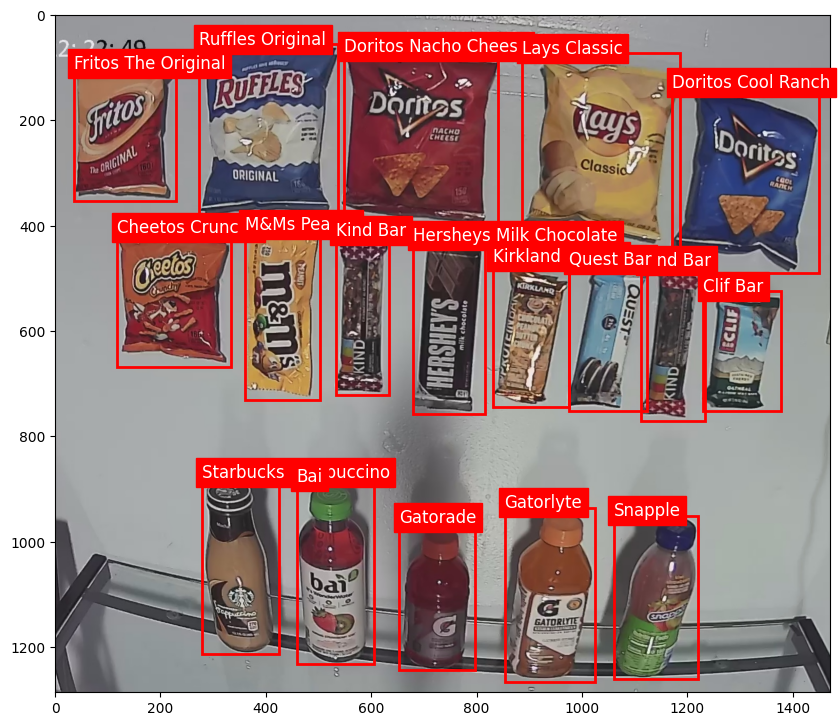

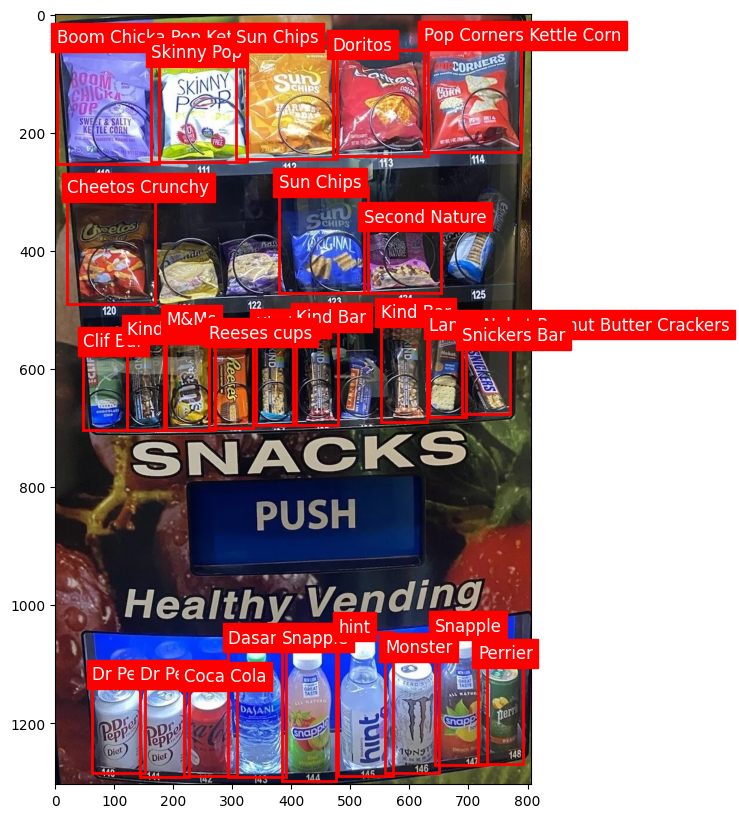

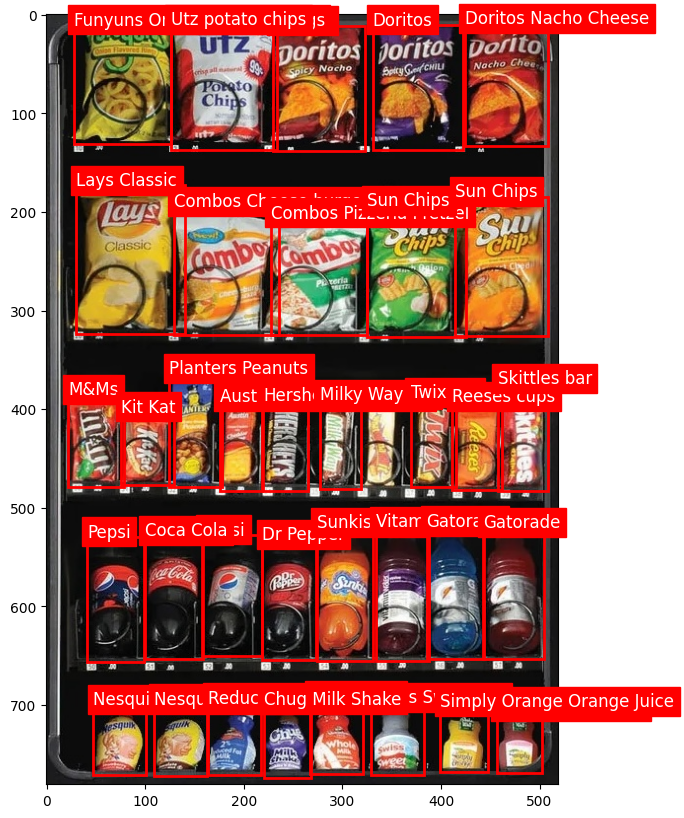

In [36]:
#@title Load Test Data
# In general, use ! if the command is one that's okay to run in a separate shell.
# Use % if the command needs to be run on the specific notebook.
if os.environ.get('HOME') == "/Users/mukund" or os.environ.get('HOME') == "/Users/Mukund":
  dataset_dir = './fnb-dataset'
else:
  dataset_dir = '.'

# Define paths to the dataset
images_dir = os.path.join(dataset_dir, 'images')
labels_dir = os.path.join(dataset_dir, 'labels')
data_yaml_path = os.path.join(dataset_dir, 'data.yaml')

# Load class labels from the data.yaml file
class_labels = load_class_labels(data_yaml_path)

# List of image files
image_files = os.listdir(images_dir)
num_images = len(image_files)

# Loop through the test images and plot them with their bounding boxes
test_data = []
for image_file in image_files:
  image_path = os.path.join(images_dir, image_file)
  if (image_file == '.DS_Store'):
    continue
  image = Image.open(image_path)
  # print(f"{img_fname} dim: {images[-1].size}")
  label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))  # Assuming the labels have the same name as the images
  labels = extract_and_plot_image_bboxes(image, label_path, class_labels)
  test_data.append({'image': image, 'filename': image_file, 'labels': labels})

In [ ]:
#@title Run Llamma-3.2-11B-Vision-Instruct Model
llm_responses = []

# prompt = "<|image|><|begin_of_text|>This image shows multiple packaged food and beverage products. Provide the brand and full product name for each item. Don't use any markdown. Additionally, provide the bounding box coordinates for each product in the format [ymin, xmin, ymax, xmax]"
# prompt = "<|image|><|begin_of_text|>Describe the image"
img_desc_prompt = """
This image shows multiple packaged food and beverage products.
Provide the full product name for each item and the corresponding bounding box coordinates. Don't use any markdowns.
Use the following format:
[Full Product Name] [ymin, xmin, ymax, xmax]
"""

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": img_desc_prompt}
    ]}
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

for test_sample in test_data:
  image = test_sample['image']
  image_fname = test_sample['filename']
  print(image_fname)
  start_time = time.time()
  inputs = processor(image,
                     input_text,
                     add_special_tokens = False,
                     return_tensors="pt"
                     ).to(model.device)

  output = model.generate(**inputs, max_new_tokens=800)
  decoded_output = processor.decode(output[0])
  print(f'User: {input_text}\nAssistant: {decoded_output}')
  end_time = time.time()
  print(f'Time taken: {end_time - start_time} seconds')

  # pred_labels = extract_pred_labels(output, image)
  pred_labels = []
  llm_responses.append({'prompt': input_text, 'model': model_id, 'response': decoded_output, 'ref_labels': test_sample['labels'], 'pred_labels': pred_labels, 'image_fname': image_fname})


In [16]:
#@title Save LLM responses from current iteration
# Generate a unique filename if needed
filename = get_unique_filename('llm_responses.json')

# Write the JSON to the unique filename
with open(filename, 'w') as f:
    json.dump(llm_responses, f)

vending2.jpg
Image length: 266048
Time taken: 21.426630973815918 seconds
Fritos The Original Corn Chips [0.079,0.057,0.194,0.239]
Ruffles Original Potato Chips [0.228,0.050,0.386,0.233]
Doritos Nacho Cheese Tortilla Chips [0.445,0.031,0.611,0.234]
Lays Classic Potato Chips [0.654,0.046,0.818,0.253]
Doritos Cool Ranch Tortilla Chips [0.838,0.084,0.977,0.280]
Cheetos Crunchy Cheese Snacks [0.132,0.329,0.232,0.540]
M&Ms Milk Chocolate Candies [0.313,0.334,0.394,0.543]
KIND Dark Chocolate Mocha Almond Whole Grain Bars [0.423,0.321,0.489,0.579]
Hersheys Milk Chocolate Bars [0.533,0.294,0.618,0.583]
Kirkland Signature Chocolate Chip Cookies [0.656,0.363,0.734,0.593]
Quest Cookies and Cream Protein Bars [0.755,0.371,0.824,0.597]
KIND Salted Caramel Almond Dark Chocolate Bars [0.880,0.400,0.957,0.591]
Starbucks Coffee Frappuccino [0.182,0.700,0.254,0.917]
Bai Strawberry Lemongrass Pomegranate Water [0.283,0.705,0.377,0.918]
Gatorade G2 Electrolyte Sports Drink [0.463,0.714,0.542,0.925]
Gatorad

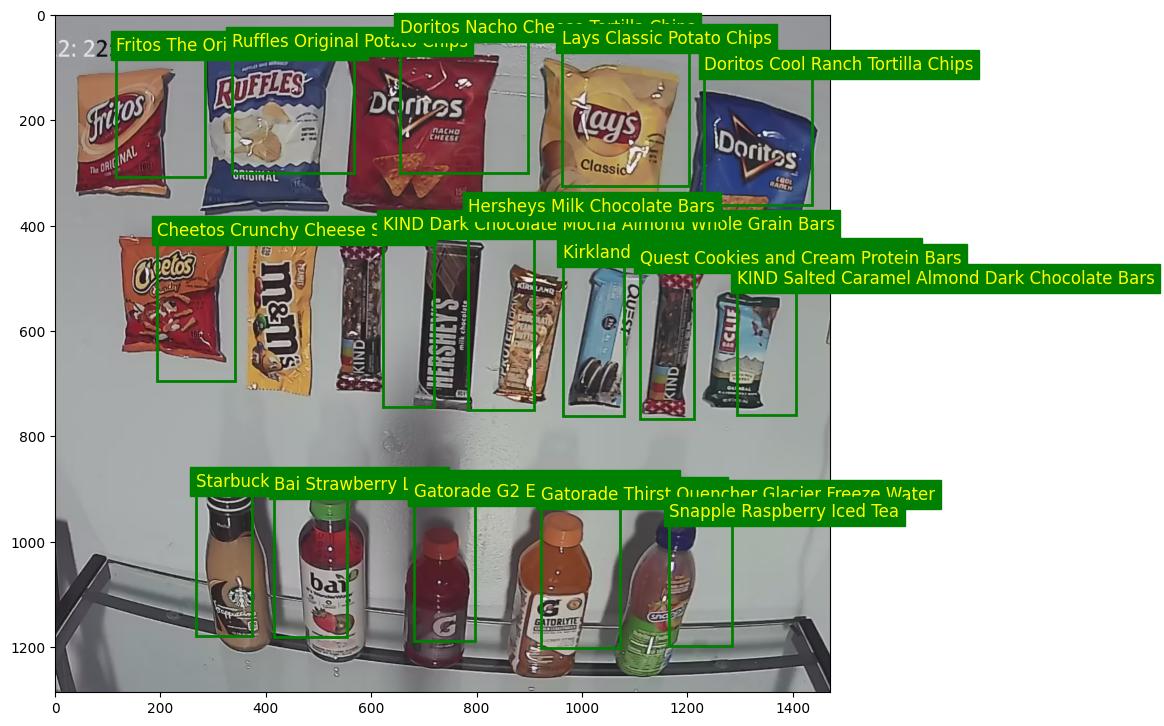

vending5-1.jpg
Image length: 284436
Time taken: 36.64671802520752 seconds
Here is the list of products with their corresponding bounding box coordinates in normalized format:

Boom Chicka Pop Sweet & Salty Kettle Corn [0.024, 0.026, 0.232, 0.197]
Skinny Pop [0.234, 0.025, 0.345, 0.170]
Sun Chips [0.349, 0.027, 0.475, 0.190]
Lay's [0.476, 0.026, 0.576, 0.190]
Red Corners [0.577, 0.024, 0.742, 0.188]
Cheetos [0.009, 0.223, 0.174, 0.317]
Takasago [0.178, 0.227, 0.228, 0.304]
Takis Fuego [0.234, 0.225, 0.354, 0.330]
Sun Chips [0.360, 0.225, 0.463, 0.333]
Uncle Ray's [0.469, 0.226, 0.564, 0.315]
Study Break [0.570, 0.224, 0.655, 0.324]
Granola Bar [0.662, 0.223, 0.792, 0.323]
M&Ms [0.008, 0.339, 0.177, 0.471]
M&Ms [0.183, 0.339, 0.264, 0.487]
Reese's [0.274, 0.336,0.328, 0.483]
Pepperidge Farm [0,337,0.356,0.503]
Kind Bar [0.369, 0.342, 0.438, 0.511]
Kind Bar [0.459, 0.343, 0.543, 0.511]
Nestle [0.556, 0.341, 0.615, 0.504]
Snickers [0.632, 0.340, 0.722, 0.501]
Snickers [0.732, 0.339, 0.813,

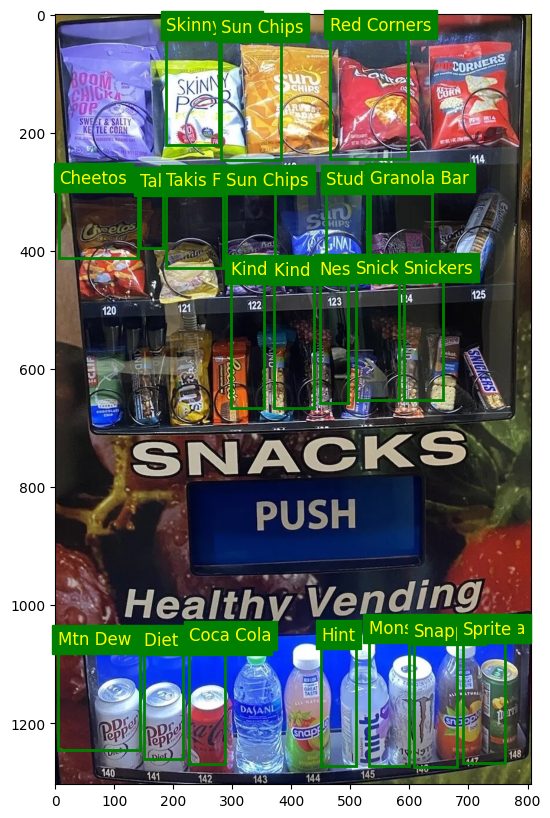

vending3-1.jpg
Image length: 118700
Time taken: 46.99304389953613 seconds
Here is the list of full product names with their corresponding bounding box coordinates:

Attention: several items are cut off and cannot be identified.

1. Funyuns Original Flavor - [0.055, 0.013, 0.183, 0.146]
2. Utz Potato Chips - [0.228, 0.005, 0.360, 0.153]
3. Doritos Spicy Nacho - [0.383, 0.007, 0.515, 0.154]
4. Doritos * action shot of large nacho chip* [Too cut off to determine flavor type] - [0.542, 0.014, 0.665, 0.154] 
5. Doritos Nacho Cheese - [0.702, 0.015, 0.835, 0.157]
6. Lays Classic - [0.053, 0.205, 0.232, 0.349]
7. Combos Pizzeria Pretzel - [0.260, 0.223, 0.387, 0.361]
8. Combos Buffalo Chicken - [0.425, 0.214, 0.554, 0.362]
9. Sun Chips Garden Veggie - [0.582, 0.220, 0.709, 0.365]
10. Sun Chips Cheddar - [0.739, 0.221, 0.867, 0.368]
11. M&M Chocolate Candies - [0.045, 0.426, 0.134, 0.555]
12. Butterfinger - [0.165, 0.433, 0.236, 0.559]
13. Taffy - [0.251, 0.425, 0.314, 0.592]
14. Peanut Crunch

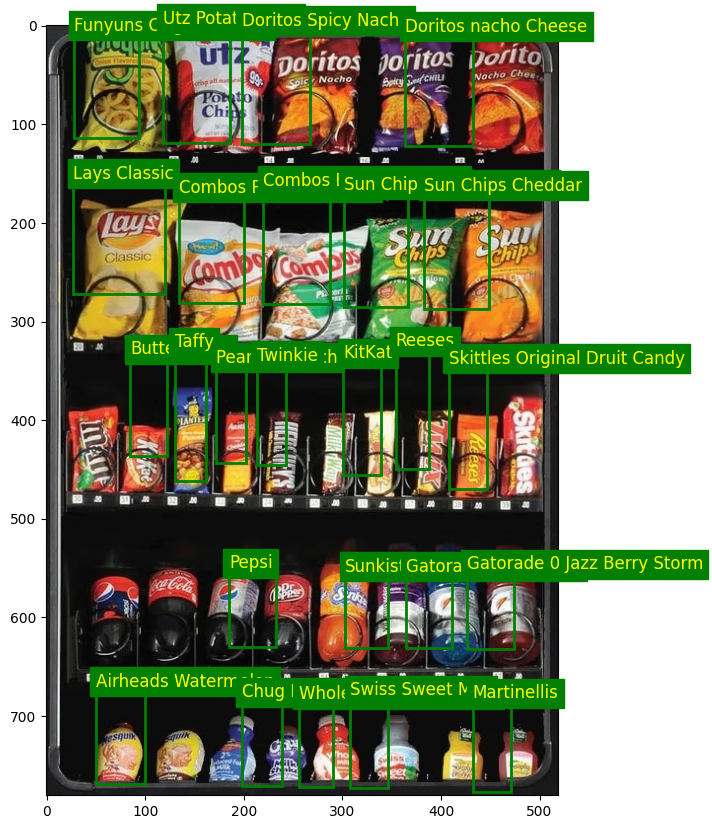

In [156]:
#@title Run Llama3.2 model from Nvidia server
invoke_url = "https://ai.api.nvidia.com/v1/gr/meta/llama-3.2-90b-vision-instruct/chat/completions"

img_desc_prompt = """
- This image shows multiple packaged food and beverage products.
- Your task is to find the full product name for each item and the corresponding bounding box coordinates in normalized format.
- Output the text in the format: <Full Product Name> [xmin, ymin, xmax, ymax]
- Do not use any markdowns.
"""

llm_responses = []
for test_sample in test_data:
  image = test_sample['image']
  image_fname = test_sample['filename']
  print(image_fname)

  # Convert the PIL Image to bytes
  buffered = io.BytesIO()
  image.save(buffered, format="JPEG") # or "PNG" if the image is PNG
  image_b64 = base64.b64encode(buffered.getvalue()).decode()
  print(f"Image length: {len(image_b64)}")

  headers = {
    "Authorization": f"Bearer {nv_nim_token}",
    "Accept": "application/json"
  }

  payload = {
    "model": 'meta/llama-3.2-90b-vision-instruct',
    "messages": [
      {
        "role": "user",
        "content": f'{img_desc_prompt} <img src="data:image/png;base64,{image_b64}" />'
      }
    ],
    "max_tokens": 1024,
    "temperature": 1.00,
    "top_p": 1.00,
    "stream": False
  }

  start_time = time.time()
  response = requests.post(invoke_url, headers=headers, json=payload)
  end_time = time.time()
  print(f'Time taken: {end_time - start_time} seconds')

  response_data = response.json()

  if (1): #(response_data['type'].find("internal-server-error") < 0):
    model_name = response_data["model"]
    text = response_data['choices'][0]['message']['content']
    usage = response_data['usage']
    print(text)
    print(usage)
    table_text = format_response_into_table(text)
    print(table_text)
    pred_labels = extract_pred_labels_llama3_2_90b(table_text, image, 'x1y1x2y2')
    llm_responses.append({'prompt': img_desc_prompt, 'model': model_name, 'response': response_data, 'ref_labels': test_sample['labels'], 'pred_labels': pred_labels, 'image_fname': image_fname})
  else:
    print("API Error")

In [157]:
#@title Save LLM responses from current iteration
# Generate a unique filename if needed
filename = get_unique_filename('llm_responses.json')

# Write the JSON to the unique filename
with open(filename, 'w') as f:
    json.dump(llm_responses, f)


Test Results for vending2.jpg


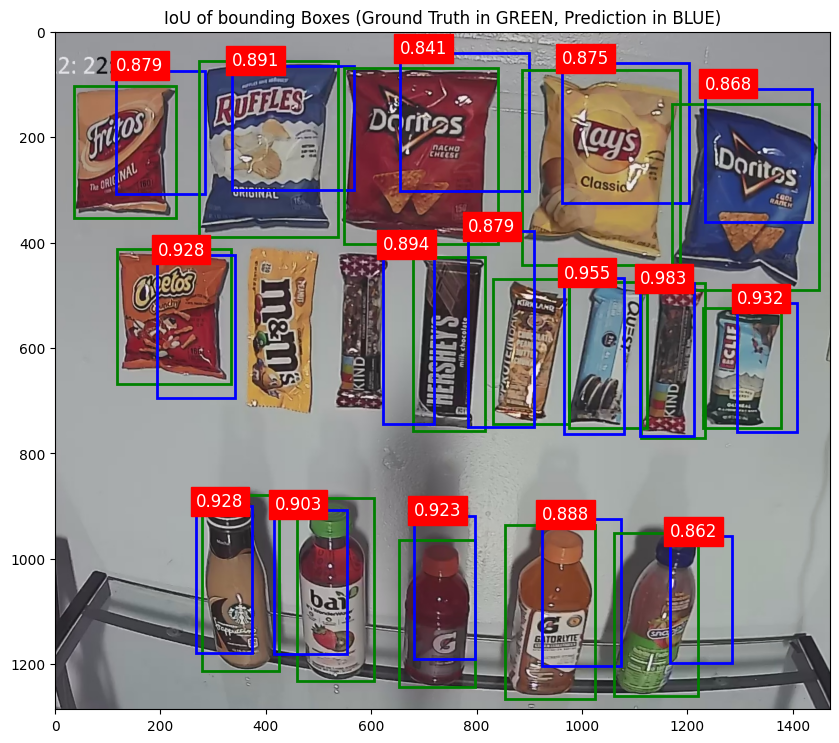

| Result   | Predicted Label                                   | True Label              |  Matched Word Count  |   IoU    |
|:---------|:--------------------------------------------------|:------------------------|:--------------------:|:--------:|
| MATCH    | Fritos The Original Corn Chips                    | Fritos The Original     |          3           | 0.878563 |
| MATCH    | Ruffles Original Potato Chips                     | Ruffles Original        |          2           | 0.891253 |
| MATCH    | Doritos Nacho Cheese Tortilla Chips               | Doritos Nacho Cheese    |          3           | 0.840736 |
| MATCH    | Lays Classic Potato Chips                         | Lays Classic            |          2           | 0.875274 |
| MATCH    | Doritos Cool Ranch Tortilla Chips                 | Doritos Cool Ranch      |          3           | 0.867546 |
| MATCH    | Cheetos Crunchy Cheese Snacks                     | Cheetos Crunchy         |          2           | 0.928474 |


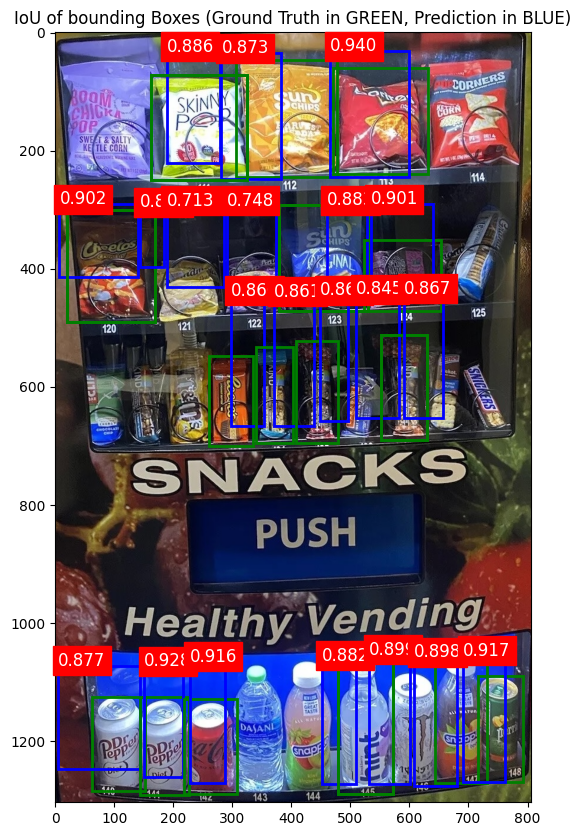

| Result   | Predicted Label     | True Label      |  Matched Word Count  |   IoU    |
|:---------|:--------------------|:----------------|:--------------------:|:--------:|
| MATCH    | Skinny Pop          | Skinny Pop      |          2           | 0.885776 |
| MATCH    | Sun Chips           | Sun Chips       |          2           | 0.873115 |
| NO MATCH | Red Corners         | Doritos         |          0           | 0.940372 |
| NO MATCH | Cheetos             | Cheetos Crunchy |          1           | 0.902218 |
| NO MATCH | Takasago            | Cheetos Crunchy |          0           | 0.802074 |
| NO MATCH | Takis Fuego         | Skinny Pop      |          0           | 0.712753 |
| MATCH    | Sun Chips           | Sun Chips       |          2           | 0.747695 |
| NO MATCH | Study Break         | Sun Chips       |          0           | 0.882969 |
| NO MATCH | Granola Bar         | Second Nature   |          0           | 0.901199 |
| NO MATCH | Kind Bar            | Reeses c

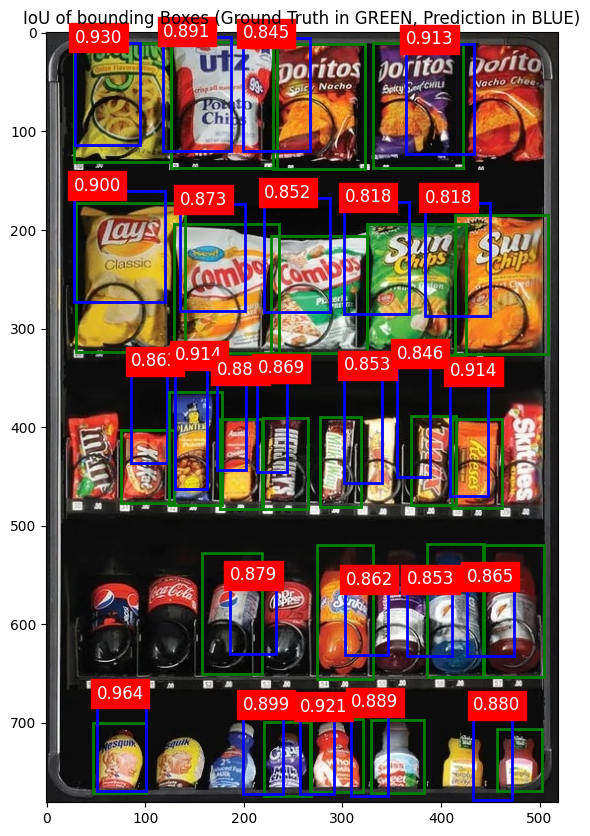

| Result   | Predicted Label               | True Label                   |  Matched Word Count  |   IoU    |
|:---------|:------------------------------|:-----------------------------|:--------------------:|:--------:|
| NO MATCH | Funyuns Original Flavor       | Funyuns Onion Flavored Rings |          1           | 0.930039 |
| MATCH    | Utz Potato Chips              | Utz potato chips             |          3           | 0.891188 |
| MATCH    | Doritos Spicy Nacho           | Doritos                      |          1           | 0.845228 |
| MATCH    | Doritos nacho Cheese          | Doritos                      |          1           | 0.912686 |
| MATCH    | Lays Classic                  | Lays Classic                 |          2           | 0.899525 |
| NO MATCH | Combos Pizzeria Pretzel       | Combos Cheese burger         |          1           | 0.872827 |
| NO MATCH | Combos Buffalo Chicken        | Combos Pizzeria Pretzel      |          1           | 0.851861 |
| MATCH   

In [165]:
#@title Show Detection Results based on IoU measure and compute Accuracy Metrics
import pandas as pd

detection_results = []
for llm_output in llm_responses:
  fname = llm_output['image_fname']
  if fname == "vending2.jpg": ind = 0
  if fname == "vending5-1.jpg": ind = 1
  if fname == "vending3-1.jpg": ind = 2

  print(f"\nTest Results for {fname}")

  image = test_data[ind]['image']
  pred_labels = llm_output['pred_labels']
  ref_labels = llm_output['ref_labels']

  pred_results = get_pred_and_plot_results(image, pred_labels, ref_labels)

  accuracy, precision, recall, f1_score = compute_detection_metrics(pred_results)
  detection_results.append([fname, accuracy, precision, recall, f1_score])

In [166]:
#@title Detection Results Summary
# Create a DataFrame from the results list
df = pd.DataFrame(detection_results, columns=["Filename", "Accuracy", "Precision", "Recall", "F1 Score"])
# # Print the DataFrame as a table
print(df.to_markdown(index=False, numalign="center", stralign="left"))

| Filename       |  Accuracy  |  Precision  |  Recall  |  F1 Score  |
|:---------------|:----------:|:-----------:|:--------:|:----------:|
| vending2.jpg   |  0.555556  |    0.625    | 0.833333 |  0.714286  |
| vending5-1.jpg |  0.307692  |  0.380952   | 0.615385 |  0.470588  |
| vending3-1.jpg |  0.342857  |    0.48     | 0.545455 |  0.510638  |
